In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 49 kB 3.8 MB/s 
     |████████████████████████████████| 232 kB 14.4 MB/s 
     |████████████████████████████████| 948 kB 63.3 MB/s 
     |████████████████████████████████| 11.1 MB 49.9 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
tfms = T.Compose([
                  T.ToTensor(),
                  T.Normalize(mean=[0.5],
                              std=[0.5]),
                  T.Lambda(lambda img: img.to(device)),
])

trn_ds = MNIST('/content/',transform = tfms, train=True, download=True)
val_ds = MNIST('/content/',transform = tfms, train=False, download=True)

trn_dl = DataLoader(trn_ds,batch_size=256,shuffle=True,drop_last=True)
val_dl = DataLoader(val_ds,batch_size=256,shuffle=False,drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [3]:
img, _ = next(iter(trn_dl))
img.shape

torch.Size([256, 1, 28, 28])

In [4]:
class AE(nn.Module):
  def __init__(self,bt_size): # bt_size = bottleneck size
    super().__init__()
    self.bt_size = bt_size
    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,64),
        nn.ReLU(inplace=True),
        nn.Linear(64,self.bt_size)
    )

    self.decoder = nn.Sequential(
        nn.Linear(self.bt_size,64),
        nn.ReLU(inplace=True),
        nn.Linear(64,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,28*28),
        nn.Tanh()
    )

  def forward(self,x):
    x = x.view(len(x),-1)
    x = self.encoder(x)
    x = self.decoder(x)
    x = x.view(len(x),1,28,28)
    return x

In [5]:
!pip install -q torch_summary
from torchsummary import summary
model = AE(bt_size=3).to(device)
summary(model,input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       100,480
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       8,256
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       195
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       256
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       8,320
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      101,136
|    └─Tanh: 2-11                        --
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       100,480
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       8,256
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       195
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       256
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       8,320
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      101,136
|    └─Tanh: 2-11                        --
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0

In [6]:
def train_batch(img,model,optimizer,criterion):
  model.train()
  output = model(img)
  loss = criterion(output,img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss

@torch.no_grad()
def validate_batch(img,model,criterion):
  model.eval()
  output = model(img)
  loss = criterion(output,img)
  return loss

model = AE(bt_size=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-5)
criterion = torch.nn.MSELoss()

In [7]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
  N = len(trn_dl)
  for ix, (img, _) in enumerate(iter(trn_dl)):
    loss = train_batch(img,model,optimizer,criterion)
    log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')
  
  for ix, (img,_) in enumerate(iter(val_dl)):
    loss = validate_batch(img,model,criterion)
    log.record(epoch+(ix+1)/N,val_loss=loss,end='\r')
  
  log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.263	val_loss: 0.200	(17.81s - 71.23s remaining)
EPOCH: 2.000	trn_loss: 0.185	val_loss: 0.174	(31.33s - 46.99s remaining)
EPOCH: 3.000	trn_loss: 0.169	val_loss: 0.163	(44.59s - 29.72s remaining)
EPOCH: 4.000	trn_loss: 0.160	val_loss: 0.156	(57.85s - 14.46s remaining)
EPOCH: 5.000	trn_loss: 0.154	val_loss: 0.152	(71.92s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2405.37it/s]


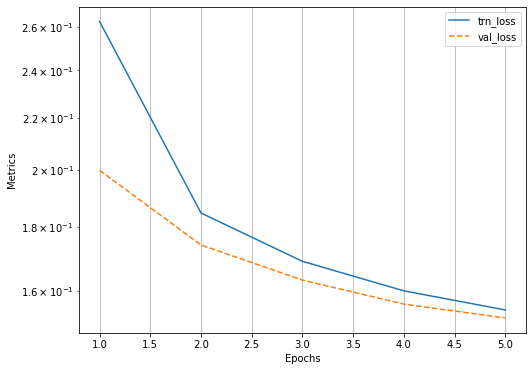

In [8]:
log.plot_epochs(log=True)

EPOCH: 1.000	trn_loss: 0.233	val_loss: 0.139	(18.43s - 73.73s remaining)
EPOCH: 2.000	trn_loss: 0.117	val_loss: 0.100	(40.06s - 60.09s remaining)
EPOCH: 3.000	trn_loss: 0.093	val_loss: 0.082	(59.79s - 39.86s remaining)
EPOCH: 4.000	trn_loss: 0.079	val_loss: 0.073	(74.15s - 18.54s remaining)
EPOCH: 5.000	trn_loss: 0.072	val_loss: 0.067	(87.49s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2632.83it/s]


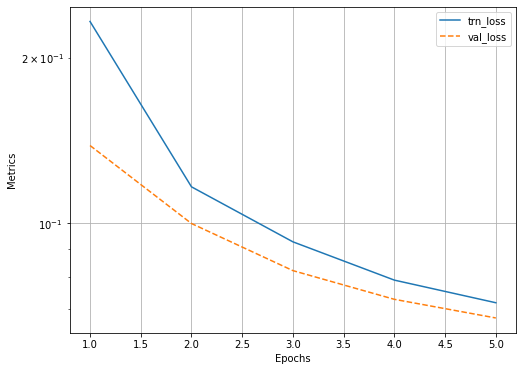

EPOCH: 1.000	trn_loss: 0.251	val_loss: 0.148	(13.41s - 53.64s remaining)
EPOCH: 2.000	trn_loss: 0.121	val_loss: 0.102	(26.79s - 40.18s remaining)
EPOCH: 3.000	trn_loss: 0.095	val_loss: 0.086	(40.03s - 26.69s remaining)
EPOCH: 4.000	trn_loss: 0.084	val_loss: 0.077	(53.73s - 13.43s remaining)
EPOCH: 5.000	trn_loss: 0.076	val_loss: 0.071	(68.62s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2850.30it/s]


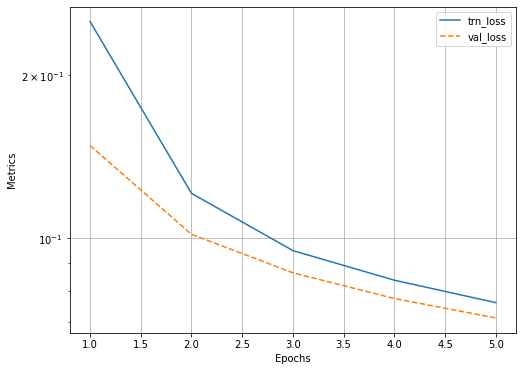

EPOCH: 1.000	trn_loss: 0.243	val_loss: 0.146	(17.06s - 68.24s remaining)
EPOCH: 2.000	trn_loss: 0.127	val_loss: 0.113	(34.36s - 51.55s remaining)
EPOCH: 3.000	trn_loss: 0.105	val_loss: 0.096	(47.70s - 31.80s remaining)
EPOCH: 4.000	trn_loss: 0.092	val_loss: 0.086	(61.00s - 15.25s remaining)
EPOCH: 5.000	trn_loss: 0.085	val_loss: 0.081	(74.31s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2689.58it/s]


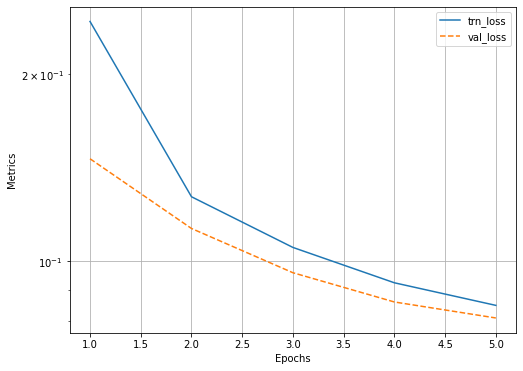

EPOCH: 1.000	trn_loss: 0.242	val_loss: 0.145	(13.27s - 53.06s remaining)
EPOCH: 2.000	trn_loss: 0.129	val_loss: 0.110	(27.77s - 41.65s remaining)
EPOCH: 3.000	trn_loss: 0.104	val_loss: 0.097	(41.42s - 27.62s remaining)
EPOCH: 4.000	trn_loss: 0.096	val_loss: 0.091	(55.22s - 13.80s remaining)
EPOCH: 5.000	trn_loss: 0.091	val_loss: 0.088	(68.85s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2548.33it/s]


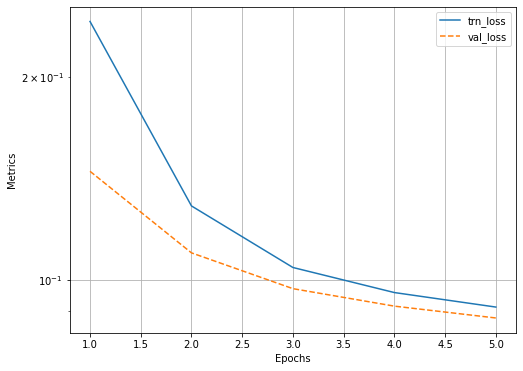

EPOCH: 1.000	trn_loss: 0.246	val_loss: 0.168	(13.86s - 55.43s remaining)
EPOCH: 2.000	trn_loss: 0.154	val_loss: 0.141	(28.16s - 42.24s remaining)
EPOCH: 3.000	trn_loss: 0.136	val_loss: 0.130	(42.46s - 28.31s remaining)
EPOCH: 4.000	trn_loss: 0.128	val_loss: 0.124	(57.10s - 14.27s remaining)
EPOCH: 5.000	trn_loss: 0.123	val_loss: 0.121	(70.70s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2664.18it/s]


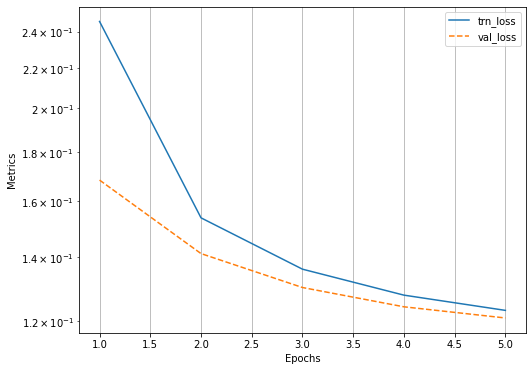

In [9]:
def AE_bt(bt_size):

  model = AE(bt_size).to(device)
  optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-5)
  criterion = torch.nn.MSELoss()

  num_epochs = 5
  log = Report(num_epochs)

  for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (img, _) in enumerate(iter(trn_dl)):
      loss = train_batch(img,model,optimizer,criterion)
      log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')
    
    for ix, (img,_) in enumerate(iter(val_dl)):
      loss = validate_batch(img,model,criterion)
      log.record(epoch+(ix+1)/N,val_loss=loss,end='\r')   
    log.report_avgs(epoch+1)
  log.plot_epochs(log=True)
  return model

aes = [AE_bt(bt) for bt in [50,25,15,10,5]]

In [ ]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()

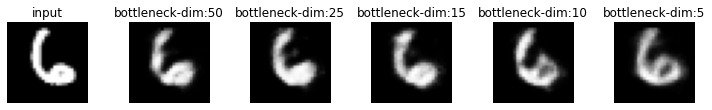

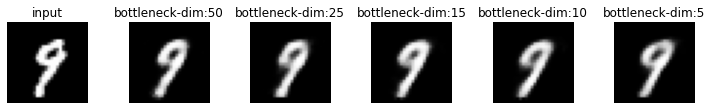

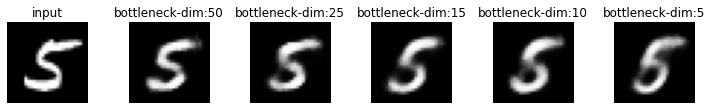

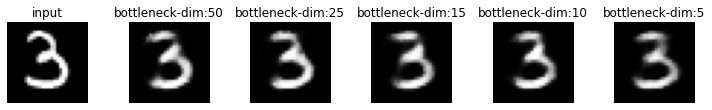

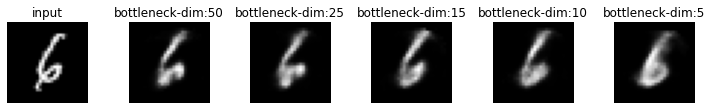

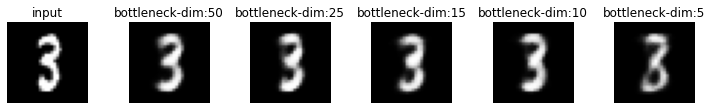

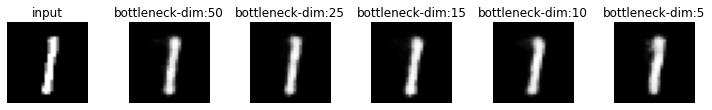

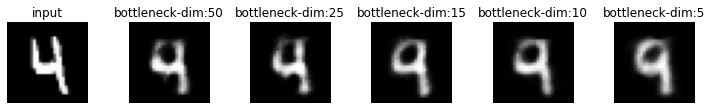

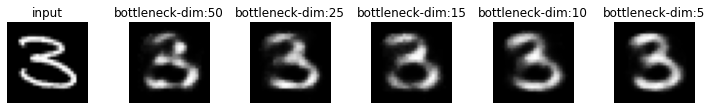

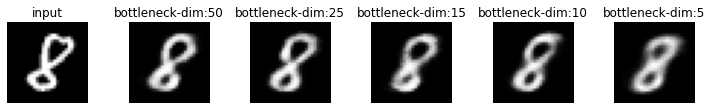

In [15]:
for _ in range(10):
  ix = np.random.randint(len(val_ds))
  im, _ = val_ds[ix]
  fig, ax = plt.subplots(1,len(aes)+1,figsize=(10,4))
  ax = iter(ax.flat)
  show(im[0],ax=next(ax),title='input')
  for model in aes:
    _im = model(im[None])[0]
    show(_im[0],ax=next(ax),title=f'bottleneck-dim:{model.bt_size}')
  plt.tight_layout()
  plt.show()